# 07 training our model on all of the data

## NOTE:
 this notebook was written in google colab. due to the shire size of the dataset running this on my pc would take way to long. do not run in vscode

In [31]:
import os

from helper_functions import create_tensorboard_callback,plot_loss_curves,compare_historys,walk_through_dir

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import mixed_precision, layers

import matplotlib as plt

In [9]:
# check gpu
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-1ef2723d-bc8f-946e-b17b-98be67327716)


In [10]:
if not os.path.exists("helper_functions.py"):
  !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
  print("already have helper function")

already have helper function


In [11]:
datasets_list = tfds.list_builders()

In [12]:
(train_data, test_data),ds_info = tfds.load(name="food101",split=["train","validation"],shuffle_files=True,as_supervised=True,with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete45IE85/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete45IE85/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [13]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [14]:
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [15]:
train_one_sample = train_data.take(1)
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [16]:
for image, label in train_one_sample:
  print(image.shape)
  print(image.dtype)
  print(label)
  print(class_names[label.numpy()])

(512, 512, 3)
<dtype: 'uint8'>
tf.Tensor(38, shape=(), dtype=int64)
fish_and_chips


## preprocessing data

In [21]:
  # Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes image to
    [img_shape, img_shape, color_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [22]:
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [23]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## adding model callbacks

In [25]:
checkpoint_path="model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

## turning on mixed precision

In [29]:
mixed_precision.set_global_policy("mixed_float16")

In [30]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## building base_model

In [39]:
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=input_shape,name="input_layer")
x = base_model(inputs,training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)

outputs = layers.Activation("softmax",dtype=tf.float32,name="softmax_float32")(x)
model=tf.keras.Model(inputs,outputs)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [40]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [41]:
for l in model.layers:
  print(l.name,l.trainable,l.dtype,l.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d_3 True float32 <Policy "mixed_float16">
dense_1 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [45]:
history_101_food_classes_feature_extraction = model.fit(train_data,epochs=3,
                                                        steps_per_epoch=(len(train_data)),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15*len(test_data)),
                                                        callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                                               experiment_name="efficientnetb0_101_classes_all_data_feature_extract"),
                                                                   model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20230221-011043
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.7177 - accuracy: 0.5823

2368/2368 [==============================] - 202s 79ms/step - loss: 1.7177 - accuracy: 0.5823 - val_loss: 1.1246 - val_accuracy: 0.6968
Epoch 2/3
2368/2368 [==============================] - ETA: 0s - loss: 1.2000 - accuracy: 0.6879

2368/2368 [==============================] - 191s 80ms/step - loss: 1.2000 - accuracy: 0.6879 - val_loss: 1.0258 - val_accuracy: 0.7195
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.0533 - accuracy: 0.7252

2368/2368 [==============================] - 186s 77ms/step - loss: 1.0533 - accuracy: 0.7252 - val_loss: 0.9899 - val_accuracy: 0.7315


In [46]:
results_feature_extract_model = model.evaluate(test_data)

790/790 [==============================] - 53s 68ms/step - loss: 0.9965 - accuracy: 0.7308


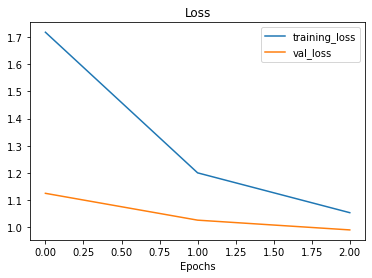

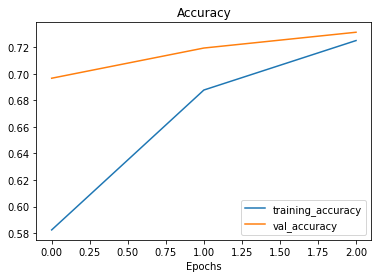

In [47]:
plot_loss_curves(history_101_food_classes_feature_extraction)

In [49]:
model.save("big_model")

TypeError: ignored

In [50]:
for l in model.layers:
  print(l.name, l.dtype)

input_layer float32
efficientnetb0 float32
global_average_pooling2d_3 float32
dense_1 float32
softmax_float32 float32


In [54]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip 

--2023-02-21 01:32:25--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.24.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16976857 (16M) [application/zip]
Saving to: ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’

07_efficientnetb0_f 100%[===================>]  16.19M  9.29MB/s    in 1.7s    

2023-02-21 01:32:27 (9.29 MB/s) - ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’ saved [16976857/16976857]



In [55]:
!mkdir downloaded_gs_model # create new dir to store downloaded feature extraction model
!unzip 07_efficientnetb0_feature_extract_model_mixed_precision.zip -d downloaded_gs_model

Archive:  07_efficientnetb0_feature_extract_model_mixed_precision.zip
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.data-00000-of-00001  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.index  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/saved_model.pb  
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/assets/


In [ ]:
loaded_gs_model = tf.keras.models.load_model("/content/downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision")

In [58]:
loaded_gs_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

## setting all layers to trainable
this confused me because were supposed to be fine-tuning rn. so then why train all the layers? but im assuming that he is going to train after our initial 3 epochs. so keep what were already learned from the above model.fit.

In [59]:
for l in loaded_gs_model.layers:
  l.trainable = True

## setting early stopping & model_checkpoint

In [60]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=3)

checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)


## fine-tuning

In [62]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

history_101_food_classes_all_data_fine_tune = loaded_gs_model.fit(train_data,
                                                          epochs=100,
                                                          steps_per_epoch=(len(train_data)),
                                                          validation_data=test_data,
                                                          validation_steps=int(0.15*len(test_data)),
                                                          callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                                               experiment_name="efficientb0_101_classes_all_data_fine_tuning"),
                                                                   model_checkpoint,
                                                                   early_stopping,
                                                                   reduce_lr])

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20230221-020116
Epoch 1/100
2368/2368 [==============================] - 209s 85ms/step - loss: 1.0502 - accuracy: 0.7242 - val_loss: 1.0715 - val_accuracy: 0.7105 - lr: 0.0010
Epoch 2/100
2368/2368 [==============================] - 195s 81ms/step - loss: 0.9718 - accuracy: 0.7450 - val_loss: 1.0635 - val_accuracy: 0.7082 - lr: 0.0010
Epoch 3/100
2368/2368 [==============================] - 185s 77ms/step - loss: 0.9141 - accuracy: 0.7593 - val_loss: 1.0730 - val_accuracy: 0.7124 - lr: 0.0010
Epoch 4/100
2368/2368 [==============================] - 184s 76ms/step - loss: 0.8669 - accuracy: 0.7701 - val_loss: 1.0603 - val_accuracy: 0.7129 - lr: 0.0010
Epoch 5/100
2368/2368 [==============================] - 186s 77ms/step - loss: 0.8258 - accuracy: 0.7802 - val_loss: 1.0588 - val_accuracy: 0.7137 - lr: 0.0010
Epoch 6/100
2368/2368 [==============================] - 183s 76ms/step - loss: 0.7910 

In [63]:
loaded_gs_model.save("big_model1")

In [64]:
loaded_gs_model.evaluate(test_data)

790/790 [==============================] - 54s 69ms/step - loss: 1.0649 - accuracy: 0.7144


[1.0648713111877441, 0.7144158482551575]

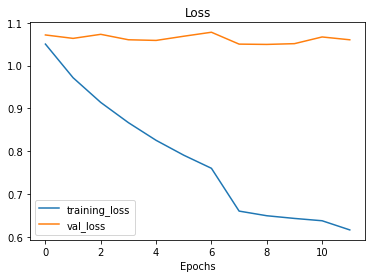

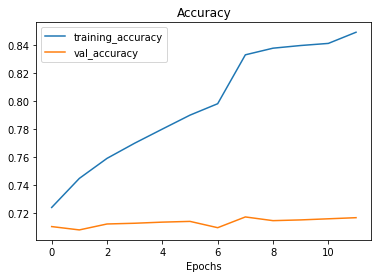

In [67]:
plot_loss_curves(history_101_food_classes_all_data_fine_tune)